In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import pickle
from sklearn.model_selection import train_test_split

In [64]:
with open('Image_Data_256x256.pkl', 'rb') as file:
    data = pickle.load(file)

In [65]:
bbox_folder = 'archive/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))
len(bb_paths)

4000

In [66]:
path = "archive/Images - 1/Images - 1/"
image_paths = glob(os.path.join(path,'*.jpg'))

bbox_folder = 'archive/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))


Image_data = []
Label_data = []
Image_path = []

for i in bb_paths:
    if os.path.exists(i):
        if os.path.getsize(i) == 0:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(data[bb_paths.index(i)])
            Label_data.append(0)
        else:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(data[bb_paths.index(i)])
            Label_data.append(1)

In [67]:
df = pd.DataFrame({'Image': Image_data, 'Label': Label_data})

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   4000 non-null   object
 1   Label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [69]:
Train_df, Test_df = df.iloc[0:3200,:],df.iloc[3200:,:]

In [70]:
np.unique(Train_df.Label, return_counts=True)

(array([0, 1]), array([ 311, 2889]))

In [71]:
np.unique(Test_df.Label, return_counts=True)

(array([0, 1]), array([ 77, 723]))

## Duplicating the class with less samples in the Training data

In [72]:
class_0 = Train_df[Train_df.Label==0]
class_1 = Train_df[Train_df.Label==1]

In [73]:
RS_Image = list(class_1.Image)
RS_Label = list(class_1.Label)

for i in range(3*len(class_0)):
    k = np.random.randint(0,len(class_0), 1)[0]
    RS_Image.append(class_0.Image.iloc[k])
    RS_Label.append(class_0.Label.iloc[k])

RS_Train_df = pd.DataFrame({'Image': RS_Image, 'Label': RS_Label})
RS_Train_df = RS_Train_df.sample(frac=1)

In [74]:
np.unique(RS_Train_df.Label, return_counts=True)

(array([0, 1]), array([ 933, 2889]))

In [75]:
from tensorflow.keras.utils import to_categorical

x_train = np.stack(RS_Train_df['Image'].values)
y_train = to_categorical(np.stack(RS_Train_df['Label'].values), num_classes = 2)

x_test = np.stack(Test_df['Image'].values)
y_test = to_categorical(np.stack(Test_df['Label'].values), num_classes = 2)

In [76]:
x_train = x_train.reshape(x_train.shape[0], *(256, 256, 3))
x_test = x_test.reshape(x_test.shape[0], *(256, 256, 3))

## VGG19

In [77]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

input_shape = (256, 256, 3)

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg19_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19_model)
model.add(Flatten())

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [78]:
features = model.predict(x_train)
x_test_features = model.predict(x_test)

25/25 [==============================] - 87s 3s/step


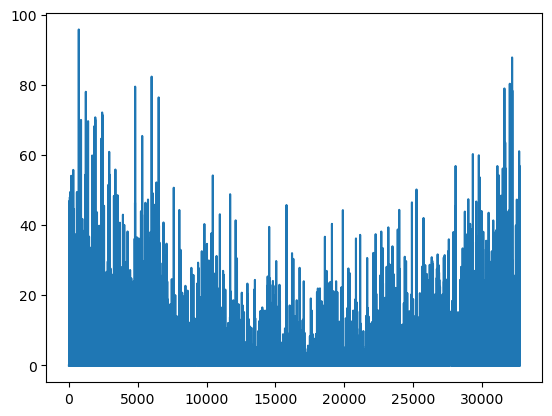

In [79]:
features = features.reshape((features.shape[0], -1))
x_test_features = x_test_features.reshape((x_test_features.shape[0], -1))
plt.plot(features[311])

0.83125
0.8297483649376823


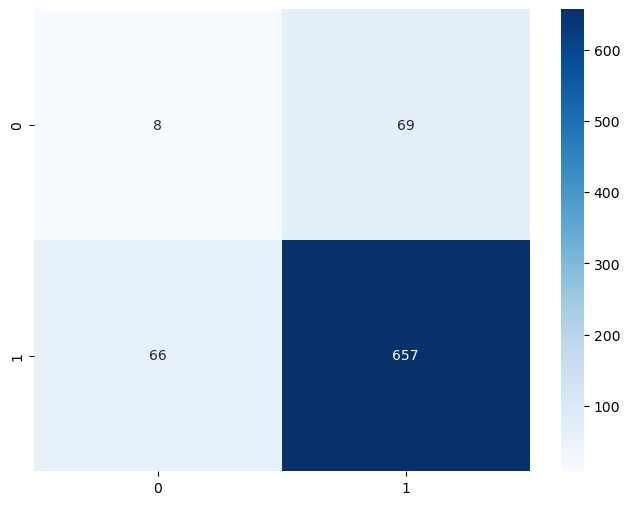

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(features, y_train)
y_pred = knn_model.predict(x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [81]:
from sklearn.linear_model import Lasso

alpha = 0.02 ## Increasing makes more features sparse
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(features, y_train)
klp = lasso_model.predict(x_test_features)

In [82]:
Lasso_features = []
for i in features:
    Lasso_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_features = np.array(Lasso_features)

Lasso_x_test_features = []
for i in x_test_features:
    Lasso_x_test_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_x_test_features = np.array(Lasso_x_test_features)

In [83]:
print(f'{len(features[0])},{len(Lasso_features[0])}')

32768,1483


0.81875
0.8212853909976912


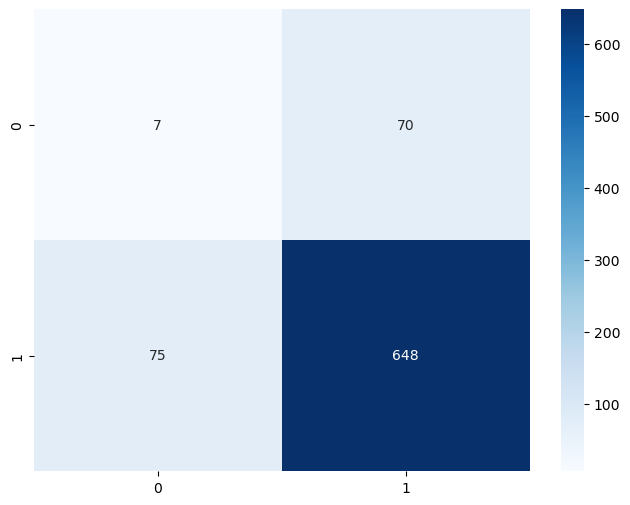

In [84]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(Lasso_features, y_train)
y_pred = knn_model.predict(Lasso_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [85]:
from scipy.optimize import minimize

def objective_function(x, A, b, lambd):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lambd * np.linalg.norm(x, 1)

def proximal_gradient_descent_scipy(A, b, lambd, x0, max_iter=10, tol=1e-4):
    result = minimize(
        fun=objective_function,
        x0=x0,
        args=(A, b, lambd),
        method='L-BFGS-B',  
        options={'maxiter': max_iter, 'disp': True}
    )

    return result.x

A = np.matrix(Lasso_features)
b = np.matrix(np.argmax(y_train, axis=1))

resulting_coefficients = proximal_gradient_descent_scipy(A, b, lambd=0.1, x0=np.zeros(A.shape[1]))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1483     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44450D+03    |proj g|=  2.08226D+05

At iterate    1    f=  3.70657D+02    |proj g|=  3.78663D+03

At iterate    2    f=  3.49984D+02    |proj g|=  2.69950D+03

At iterate    3    f=  2.81852D+02    |proj g|=  3.43144D+03

At iterate    4    f=  2.45608D+02    |proj g|=  5.72877D+03

At iterate    5    f=  2.08452D+02    |proj g|=  2.99960D+03

At iterate    6    f=  1.71857D+02    |proj g|=  1.58507D+03

At iterate    7    f=  1.57742D+02    |proj g|=  1.56319D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [86]:
rc = np.round(resulting_coefficients,3)
sum(rc!=0)

620

In [87]:
PGD_features = []
for i in Lasso_features:
    PGD_features.append(np.array(i[rc != 0]))
PGD_features = np.array(PGD_features)

PGD_x_test_features = []
for i in Lasso_x_test_features:
    PGD_x_test_features.append(np.array(i[rc != 0]))
PGD_x_test_features = np.array(PGD_x_test_features)

0.8325
0.829450804109895


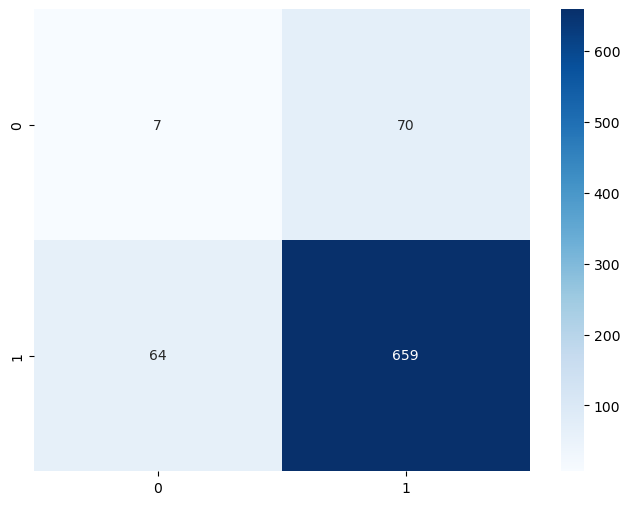

In [88]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(PGD_features, y_train)
y_pred = knn_model.predict(PGD_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

0.8325
0.829450804109895


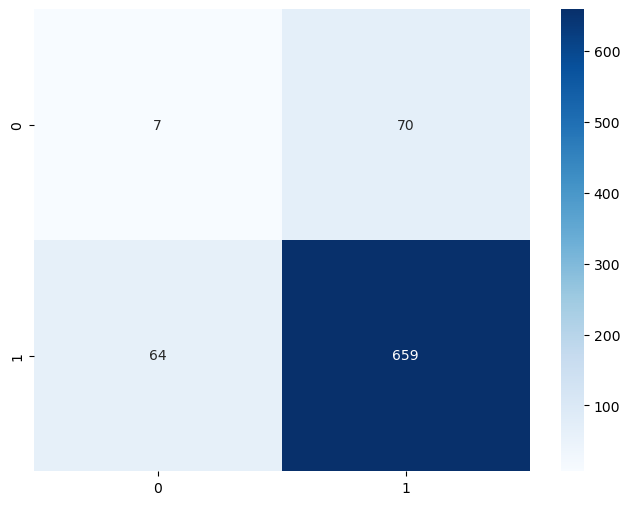

In [89]:
from sklearn import svm

svc = svm.OneClassSVM(nu=0.5, kernel='rbf', gamma=0.1)

svc.fit(PGD_features)
test_predictions = svc.predict(PGD_x_test_features)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()